In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

# import statsmodels.api as sm
# import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency

In [2]:
# load stimuli info with model priority
DIR_STIMULI = '../exp-source/exp_datasource/screen_images/'
TARGET_CATEGORIES = ['dog', 'bird', 'turtle', 'insect']
IMAGE_TYPES = ['clean', 'foveated', 'blurred'] # 'foveated',
display_info =  np.load('../exp-source/display_info.npy', allow_pickle=True)
print('# of total stimuli: ', len(display_info))
display_info[0]

# of total stimuli:  2000


{'display_idx': 50,
 'display_filename': 'TP_dog_d50',
 'condition': 'TP',
 'target_label': 'dog',
 'target_index': 0,
 'clean_objlist': ['../data/imagenet_val_segmented_resized/nontarget/n03980874_ILSVRC2012_val_00017658.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n04192698_ILSVRC2012_val_00036370.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n07860988_ILSVRC2012_val_00033051.JPEG',
  '../data/imagenet_val_segmented_resized/dog/n02107574_ILSVRC2012_val_00005587.JPEG'],
 'foveated_objlist': ['../data/imagenet_val_segmented_resized_foveated/nontarget/TP_dog_d50-b0-n03980874_ILSVRC2012_val_00017658.JPEG',
  '../data/imagenet_val_segmented_resized_foveated/nontarget/TP_dog_d50-b1-n04192698_ILSVRC2012_val_00036370.JPEG',
  '../data/imagenet_val_segmented_resized_foveated/nontarget/TP_dog_d50-b2-n07860988_ILSVRC2012_val_00033051.JPEG',
  '../data/imagenet_val_segmented_resized_foveated/dog/TP_dog_d50-b3-n02107574_ILSVRC2012_val_00005587.JPEG'],
 'target_idx_in_ob

In [3]:
# Helper function: compute bootstrapped standard error for the mean
def bootstrap_se(data, n_boot=1000):
    data = np.array(data)
    # generate bootstrap replicates of the mean
    boot_means = [np.mean(np.random.choice(data, size=len(data), replace=True))
                  for _ in range(n_boot)]
    return np.std(boot_means)


In [4]:
# ---------------------------
# 1. Create a raw data DataFrame for ANOVA
# ---------------------------
raw_data_list = []

for image_type in IMAGE_TYPES:
    # Load the correct files for each image type
    our_results = np.load(f'../exp-source/our_results_{image_type}.npy', allow_pickle=True)
    template_results = np.load(f'../exp-source/template_results_{image_type}.npy', allow_pickle=True)
    
    for target in TARGET_CATEGORIES:
        # Filter display_info for the current target and condition
        display_info_target = [info for info in display_info 
                               if info['target_label'] == target and info['condition'] == 'TP']
        
        for info in display_info_target:
            display_idx = info['display_idx']
            # Look up corresponding entries in each results file
            our_entry = next((item for item in our_results if item['display_idx'] == display_idx), None)
            temp_entry = next((item for item in template_results if item['display_idx'] == display_idx), None)
            
            if our_entry is not None:
                raw_data_list.append({
                    'Display Index': display_idx,
                    'Image Type': image_type,
                    'Target': target,
                    'Model': 'Our',
                    'Accuracy': our_entry['acc']
                })
            if temp_entry is not None:
                raw_data_list.append({
                    'Display Index': display_idx,
                    'Image Type': image_type,
                    'Target': target,
                    'Model': 'Template',
                    'Accuracy': temp_entry['acc']
                })

# Create a DataFrame from raw observations
df_raw = pd.DataFrame(raw_data_list)
print("Raw data head:")
print(df_raw.head())


Raw data head:
   Display Index Image Type Target     Model  Accuracy
0             50      clean    dog       Our         1
1             50      clean    dog  Template         1
2             51      clean    dog       Our         1
3             51      clean    dog  Template         1
4             52      clean    dog       Our         1


In [5]:

# Assuming df_raw is your DataFrame with columns:
# 'Image_Type', 'Target', 'Model', and 'Accuracy' (0 or 1)
# If you wish to collapse across Image_Type, or run separately for each Image_Type,
# adjust the groupby accordingly.

# For example, to collapse across all image types:
contingency_table = pd.crosstab(index=[df_raw['Target'], df_raw['Model']],
                                columns=df_raw['Accuracy'],
                                dropna=False)
print("Contingency Table (rows: Target and Model; columns: Accuracy):")
print(contingency_table)

# Run chi-square test-of-independence
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("\nChi-Square Test Results:")
print("Chi2 Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-value:", p_value)

# If desired, print the expected counts:
print("\nExpected Counts:")
print(expected)

Contingency Table (rows: Target and Model; columns: Accuracy):
Accuracy           0    1
Target Model             
bird   Our        81  669
       Template  163  587
dog    Our       130  620
       Template  350  400
insect Our       180  570
       Template   95  655
turtle Our       220  530
       Template   82  668

Chi-Square Test Results:
Chi2 Statistic: 451.49776744491896
Degrees of Freedom: 7
P-value: 2.1174250670692605e-93

Expected Counts:
[[162.625 587.375]
 [162.625 587.375]
 [162.625 587.375]
 [162.625 587.375]
 [162.625 587.375]
 [162.625 587.375]
 [162.625 587.375]
 [162.625 587.375]]


In [39]:
# ---------------------------------------------
# Test for Target: Does accuracy differ across Targets?
# Collapse across Models
target_table = pd.crosstab(index=df_raw['Target'], columns=df_raw['Accuracy'])
print("Contingency Table for Target vs Accuracy:")
print(target_table)

chi2_target, p_target, dof_target, expected_target = chi2_contingency(target_table)
print("\nChi-Square Test for Target:")
print("Chi2 Statistic:", chi2_target)
print("Degrees of Freedom:", dof_target)
print("P-value:", p_target)
print("Expected Counts:")
print(expected_target)

# ---------------------------------------------
# Test for Model: Does accuracy differ between Models?
# Collapse across Targets
model_table = pd.crosstab(index=df_raw['Model'], columns=df_raw['Accuracy'])
print("\nContingency Table for Model vs Accuracy:")
print(model_table)

chi2_model, p_model, dof_model, expected_model = chi2_contingency(model_table)
print("\nChi-Square Test for Model:")
print("Chi2 Statistic:", chi2_model)
print("Degrees of Freedom:", dof_model)
print("P-value:", p_model)
print("Expected Counts:")
print(expected_model)

Contingency Table for Target vs Accuracy:
Accuracy    0     1
Target             
bird      244  1256
dog       480  1020
insect    275  1225
turtle    302  1198

Chi-Square Test for Target:
Chi2 Statistic: 131.96488565526315
Degrees of Freedom: 3
P-value: 2.0399184288000393e-28
Expected Counts:
[[ 325.25 1174.75]
 [ 325.25 1174.75]
 [ 325.25 1174.75]
 [ 325.25 1174.75]]

Contingency Table for Model vs Accuracy:
Accuracy    0     1
Model              
Our       611  2389
Template  690  2310

Chi-Square Test for Model:
Chi2 Statistic: 5.971146329562327
Degrees of Freedom: 1
P-value: 0.014541824589570106
Expected Counts:
[[ 650.5 2349.5]
 [ 650.5 2349.5]]


In [9]:
# only on clean/foveated/blurred images
for image_type in IMAGE_TYPES:
    print(f"\n==================Analyzing image type: {image_type}")
    
    # Filter the raw data for the current image type
    df_selected = df_raw[df_raw['Image Type']==image_type]
    # Collapse across Models
    target_table = pd.crosstab(index=df_selected['Target'], columns=df_selected['Accuracy'])
    print("Contingency Table for Target vs Accuracy:")
    print(target_table)

    chi2_target, p_target, dof_target, expected_target = chi2_contingency(target_table)
    print("\nChi-Square Test for Target:")
    print("Chi2 Statistic:", chi2_target)
    print("Degrees of Freedom:", dof_target)
    print("P-value:", p_target)
    print("Expected Counts:")
    print(expected_target)

    # ---------------------------------------------
    # Test for Model: Does accuracy differ between Models?
    # Collapse across Targets
    model_table = pd.crosstab(index=df_selected['Model'], columns=df_selected['Accuracy'])
    print("\nContingency Table for Model vs Accuracy:")
    print(model_table)

    chi2_model, p_model, dof_model, expected_model = chi2_contingency(model_table)
    print("\nChi-Square Test for Model:")
    print("Chi2 Statistic:", chi2_model)
    print("Degrees of Freedom:", dof_model)
    print("P-value:", p_model)
    print("Expected Counts:")
    print(expected_model)


==================Analyzing image type: clean
Contingency Table for Target vs Accuracy:
Accuracy    0    1
Target            
bird       42  458
dog       113  387
insect     27  473
turtle     51  449

Chi-Square Test for Target:
Chi2 Statistic: 83.37401721110197
Degrees of Freedom: 3
P-value: 5.7961014418620556e-18
Expected Counts:
[[ 58.25 441.75]
 [ 58.25 441.75]
 [ 58.25 441.75]
 [ 58.25 441.75]]

Contingency Table for Model vs Accuracy:
Accuracy    0    1
Model             
Our        92  908
Template  141  859

Chi-Square Test for Model:
Chi2 Statistic: 11.192316940766704
Degrees of Freedom: 1
P-value: 0.0008213671894156664
Expected Counts:
[[116.5 883.5]
 [116.5 883.5]]

==================Analyzing image type: foveated
Contingency Table for Target vs Accuracy:
Accuracy    0    1
Target            
bird       70  430
dog       150  350
insect     99  401
turtle     89  411

Chi-Square Test for Target:
Chi2 Statistic: 43.1815942457385
Degrees of Freedom: 3
P-value: 2.25192850662

Table saved to accuracy_table.csv


/home/young/anaconda3/envs/wormholes/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/young/anaconda3/envs/wormholes/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/tmp/ipykernel_308154/1580763956.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(
/home/young/anaconda3/envs/wormholes/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The 

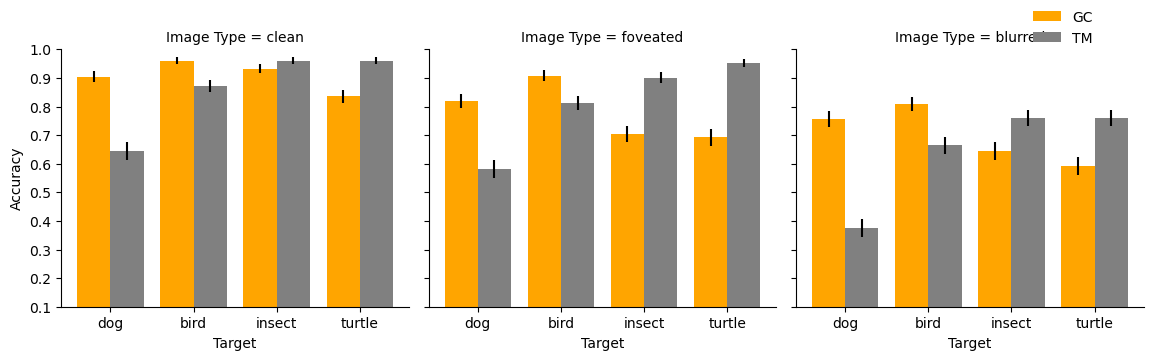

In [43]:
SAVE_FIG= False

# Define the desired orders
target_order = ['dog', 'bird', 'insect', 'turtle']
img_type_order = ['clean', 'foveated', 'blurred']

# ---------------------------
# 3. Compute summary statistics (including bootstrapped SE) for visualization
# ---------------------------
# First, compute summary statistics per (Image Type, Target, Model)
summary = df_raw.groupby(['Image Type', 'Target', 'Model']).agg(
    N=('Accuracy', 'count'),
    Mean_Accuracy=('Accuracy', 'mean'),
    SD_Accuracy=('Accuracy', 'std')
).reset_index()

summary['SEM'] = summary['SD_Accuracy'] / np.sqrt(summary['N']-1)


# Compute bootstrapped SE for each group
# boot_se_list = []
# for (img, target, model), group in df_raw.groupby(['Image Type', 'Target', 'Model']):
#     se = bootstrap_se(group['Accuracy'].values)
#     boot_se_list.append({
#         'Image Type': img,
#         'Target': target,
#         'Model': model,
#         'Boot_SE': se
#     })
# boot_se_df = pd.DataFrame(boot_se_list)

# Merge bootstrapped SE into the summary table
# summary = pd.merge(summary, boot_se_df, on=['Image Type', 'Target', 'Model'])
# print("\nSummary Table:")
# print(summary)

# Optionally, save the summary table to CSV
summary.to_csv('../results/accuracy_table.csv', index=False)
print("Table saved to accuracy_table.csv")

# Force the categorical order for plotting
summary['Target'] = pd.Categorical(summary['Target'], categories=target_order, ordered=True)
summary['Image Type'] = pd.Categorical(summary['Image Type'], categories=img_type_order, ordered=True)

# Define a custom palette mapping
custom_palette = {'Our': 'orange', 'Template': 'gray'}

# ---------------------------
# 4. Plotting the results with bootstrapped SE as error bars
# ---------------------------
#sns.set(style="whitegrid")
# Change the height parameter (lowering the figure height)
g = sns.catplot(
    data=summary, kind="bar",
    x="Target", y="Mean_Accuracy", hue="Model",
    col="Image Type",
    order=target_order,               # set target order on x-axis
    col_order=img_type_order,         # set facet (Image Type) order
    ci=None, palette=custom_palette,  # use custom palette for the bars
    height=3.5, aspect=1,          # modified height (and aspect ratio)
    saturation=1
)

# Change the y-axis label from "Mean_Accuracy" to "Accuracy"
g.set_axis_labels("Target", "Accuracy")

# Define x-offsets for each model (assuming two models: "Our" and "Template")
hue_offsets = {'Our': -0.2, 'Template': 0.2}

# Loop over each facet to manually add error bars using bootstrapped SE
for ax in g.axes.flat:
    # Extract the image type value from the facet title
    title = ax.get_title()  # e.g., "Image Type = clean"
    image_type_val = title.split(' = ')[-1]
    
    # Loop through the target order to ensure the order we desire
    for i, target in enumerate(target_order):
        for model, offset in hue_offsets.items():
            subset = summary[(summary['Image Type'] == image_type_val) & 
                             (summary['Target'] == target) & 
                             (summary['Model'] == model)]
            if not subset.empty:
                mean_val = subset['Mean_Accuracy'].values[0]
                se = subset['SEM'].values[0]
                # Calculate x position: i (position for target) + offset for model
                x_pos = i + offset
                ax.errorbar(x=x_pos, y=mean_val, yerr=se,
                            fmt='none', c='black', capsize=0)
    # Remove bar edges by not setting an edge color (or explicitly set to 'none')
    # for patch in ax.patches:
    #     patch.set_edgecolor('black')
    #     patch.set_linewidth(1)
    # Set the y-axis limits from 0.1 to 1
    ax.set_ylim(0.1, 1)

plt.subplots_adjust(top=0.85)
#g.fig.suptitle('Mean Accuracy with SE per Target and Image Type')

# ---------------------------
# Update the legend names from "Our" and "Template" to "GC" and "TM"
# ---------------------------
new_labels = {'Our': 'GC', 'Template': 'TM'}
# Loop over each legend text and update accordingly
for t in g._legend.texts:
    original_text = t.get_text()
    if original_text in new_labels:
        t.set_text(new_labels[original_text])

g._legend.set_bbox_to_anchor((0.95, 0.95))
g._legend.set_title('')

plt.tight_layout()
plt.savefig("../figures/savefig/acc_by_target_comparison.png", dpi=300,  bbox_inches='tight')
plt.show()


/home/young/anaconda3/envs/wormholes/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/young/anaconda3/envs/wormholes/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/tmp/ipykernel_308154/3935249657.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(
/home/young/anaconda3/envs/wormholes/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The d

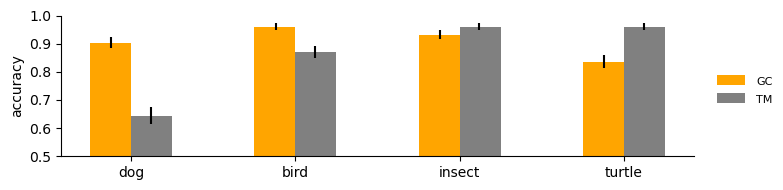

In [54]:
# Filter summary to only include "clean" image type
clean_summary = summary[summary['Image Type'] == 'clean']

#sns.set(style="whitegrid")
# Create a bar plot without faceting
g = sns.catplot(
    data=clean_summary, kind="bar",
    x="Target", y="Mean_Accuracy", hue="Model",
    order=target_order,      # set target order on x-axis
    ci=None, palette=custom_palette,
    height=2, aspect=3, saturation=1,
    width=0.5

)

g.set_axis_labels("", "accuracy")

# Define x-offsets for each model (assuming two models: "Our" and "Template")
hue_offsets = {'Our': -0.12, 'Template': 0.12}

# Since there's only one facet, use g.ax for the single axis
ax = g.ax
for i, target in enumerate(target_order):
    for model, offset in hue_offsets.items():
        subset = clean_summary[(clean_summary['Target'] == target) &
                               (clean_summary['Model'] == model)]
        if not subset.empty:
            mean_val = subset['Mean_Accuracy'].values[0]
            se = subset['SEM'].values[0]
            # Calculate x position: target index plus model offset
            x_pos = i + offset
            ax.errorbar(x=x_pos, y=mean_val, yerr=se,
                        fmt='none', c='black', capsize=0)

# Set the y-axis limits from 0.1 to 1
ax.set_ylim(0.5, 1)

# plt.subplots_adjust(top=0.85)
# g.fig.subplots_adjust(right=0.8)
#plt.title('Mean Accuracy with Bootstrapped SE for Clean Image Type')

# Update the legend names from "Our" and "Template" to "GC" and "TM"
new_labels = {'Our': 'GC', 'Template': 'TM'}
for t in g._legend.texts:
    original_text = t.get_text()
    if original_text in new_labels:
        t.set_text(new_labels[original_text])
g._legend.set_title('')
# Make the legend text bigger
for t in g._legend.texts:
    t.set_fontsize(8)  # Increase font size here
    
# Position the legend inside the plot area at (0.85, 0.8)
g._legend.set_bbox_to_anchor((1.1, 0.5))
# Ensure the legend has a frame with a white background
# g._legend.set_frame_on(True)
# g._legend.get_frame().set_facecolor('white')

plt.tight_layout()
plt.savefig("../figures/savefig/acc_by_target_clean.png", dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_1018345/283563715.py:42: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(
/home/young/anaconda3/envs/wormholes/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/young/anaconda3/envs/wormholes/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


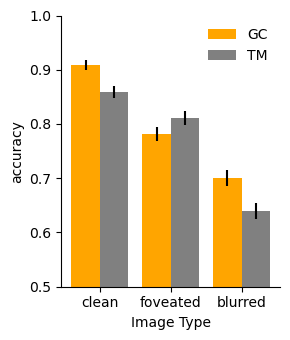

,Image Type,Model,N,Mean_Accuracy,SD_Accuracy,SEM
0,blurred,Our,1000,0.700,0.458487,0.014506
1,blurred,Template,1000,0.640,0.480240,0.015194
2,clean,Our,1000,0.908,0.289171,0.009149
3,clean,Template,1000,0.859,0.348196,0.011016
4,foveated,Our,1000,0.781,0.413776,0.013091
5,foveated,Template,1000,0.811,0.391705,0.012393


In [7]:
# ---------------------------
# Aggregate over target categories: compute summary statistics per (Image Type, Model)
# ---------------------------
summary2 = df_raw.groupby(['Image Type', 'Model']).agg(
    N=('Accuracy', 'count'),
    Mean_Accuracy=('Accuracy', 'mean'),
    SD_Accuracy=('Accuracy', 'std')
).reset_index()

summary2['SEM'] = summary2['SD_Accuracy'] / np.sqrt(summary2['N']-1)

# # Compute bootstrapped SE for each (Image Type, Model) group
# boot_se_list2 = []
# for (img, model), group in df_raw.groupby(['Image Type', 'Model']):
#     se = bootstrap_se(group['Accuracy'].values)
#     boot_se_list2.append({
#         'Image Type': img,
#         'Model': model,
#         'Boot_SE': se
#     })
# boot_se_df2 = pd.DataFrame(boot_se_list2)

# # Merge bootstrapped SE into the summary table
# summary2 = pd.merge(summary2, boot_se_df2, on=['Image Type', 'Model'])
# print("\nAggregated Summary Table:")
# print(summary2)

# Define the desired order for Image Type
img_type_order = ['clean', 'foveated', 'blurred']
summary2['Image Type'] = pd.Categorical(summary2['Image Type'], categories=img_type_order, ordered=True)

# Define a custom palette: Our is orange, Template is gray
custom_palette = {'Our': 'orange', 'Template': 'gray'}

# ---------------------------
# Plotting: Barplot with bootstrapped SE error bars (aggregated over targets)
# ---------------------------
#sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(3, 3.5))

# Create the barplot
barplot = sns.barplot(
    data=summary2,
    x="Image Type", y="Mean_Accuracy", hue="Model",
    order=img_type_order, palette=custom_palette,
    ci=None, ax=ax,
    saturation=1
)

# Define x-offsets for each model (assuming two models: "Our" and "Template")
# Here, each categorical x position is at 0, 1, 2, and we offset the bars within each category.
hue_offsets = {'Our': -0.2, 'Template': 0.2}

# Manually add error bars using the bootstrapped SE
for i, image_type in enumerate(img_type_order):
    for model, offset in hue_offsets.items():
        subset = summary2[(summary2['Image Type'] == image_type) & (summary2['Model'] == model)]
        if not subset.empty:
            mean_val = subset['Mean_Accuracy'].values[0]
            se = subset['SEM'].values[0]
            # Compute x position: categorical position plus offset
            x_pos = i + offset
            ax.errorbar(x=x_pos, y=mean_val, yerr=se, fmt='none',
                        c='black', capsize=0)

# Remove black edges from bars
for patch in ax.patches:
    patch.set_edgecolor('none')
    patch.set_linewidth(1)

# Set y-axis limits to 0.1 to 1
ax.set_ylim(0.5, 1)

ax.set_ylabel("accuracy")

# Final plot adjustments
ax.set_title("")

# Update legend: remove legend box and update labels from "Our"/"Template" to "GC"/"TM"
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
    if label == 'Our':
        new_labels.append('GC')
    elif label == 'Template':
        new_labels.append('TM')
    else:
        new_labels.append(label)
ax.legend(handles, new_labels, loc='upper right', frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("../figures/savefig/acc_by_image_type.png", dpi=300,  bbox_inches='tight')
plt.show()

display(summary2)